In [3]:
from IPython import display

# File Processing
import glob
import os
from os.path import isdir, join
from pathlib import Path

# Math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
from scipy import signal
from scipy.io import wavfile

# Data Plotting and Visualizations
from PIL import Image
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns

# Sklearn Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Tensorflow
import tensorflow as tf
from tensorflow.python.data import Dataset
import tensorflow_hub as hub

tf.logging.set_verbosity(tf.logging.ERROR)
tf.logging.set_verbosity(tf.logging.INFO)
pd.options.display.max_rows = 40
pd.options.display.float_format = '{:.2f}'.format

In [4]:
TRAIN_WAVFILES_PATH = './train/audio/'
TRAIN_SPECT_PATH = './train/spect/'
TRAIN_SPECT_TMP_PATH = './train/spect_tmp_2/'
#PREDICTION_LABELS = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "unknown"]
PREDICTION_LABELS = ["yes", "no"]

## Prepare Data - From Image Spectrograms -> Numpy Arrays

In [5]:
all_images = []
subfolder_lens = []
for x in range(len(PREDICTION_LABELS)):
    subfolder_files = [x for x in os.listdir(TRAIN_SPECT_PATH + PREDICTION_LABELS[x]) if '.jpg' in x]
    number_of_files = len(subfolder_files)
    print("index: %d - folder name: %s - number of files: %d" % (x, PREDICTION_LABELS[x], number_of_files))
    number_of_files = 2350 #len(number_of_files)
    subfolder_lens.append(number_of_files)
    for y in range(number_of_files):
        image_path = TRAIN_SPECT_PATH + PREDICTION_LABELS[x] + '/' + subfolder_files[y]
        image = np.asarray(Image.open(image_path))
        image = np.append(image, x)
        all_images.append(image)

index: 0 - folder name: yes - number of files: 2377
index: 1 - folder name: no - number of files: 2375


In [6]:
total_images = len(all_images)
len_train_data = int(total_images *0.8)
len_validation_data = int(total_images *0.2)

In [7]:
all_images = np.asarray(np.random.permutation(all_images))
all_examples = all_images[:, :-1].reshape(-1, 96,96,3)
all_labels = all_images[:, -1:]
training_examples = all_examples[:len_train_data].astype(np.float32)
validation_examples = all_examples[len_train_data:].astype(np.float32)
training_labels = all_labels[:len_train_data]
validation_labels = all_labels[len_train_data:]

In [8]:
print('shape of original np array for all images:')
print(all_images.shape)

print("\ntrain/validation split")
print('train len :', len_train_data)
print('validation len:', len_validation_data)

print('\ntraining examples shape:')
print(training_examples.shape)
print('training labels shape:')
print(training_labels.shape)
print('validation examples shape:')
print(validation_examples.shape)
print('validation labels shape:')
print(validation_labels.shape)

shape of original np array for all images:
(4700, 27649)

train/validation split
train len : 3760
validation len: 940

training examples shape:
(3760, 96, 96, 3)
training labels shape:
(3760, 1)
validation examples shape:
(940, 96, 96, 3)
validation labels shape:
(940, 1)


## Defining the Model and Model Inputs

In [9]:
def mobilenet_v2_35_model_fn(features, labels, mode, params):
    module = hub.Module("https://tfhub.dev/google/imagenet/mobilenet_v2_035_96/feature_vector/1")
    input_layer = features["x"]
    outputs = module(input_layer)
    print("outputs:")
    print(outputs.shape)

    logits = tf.layers.dense(inputs=outputs, units=2)
    print("flattened layer")
    print(logits.shape)
    
    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    print("predictions generated")

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    print("Calculate Loss (for both TRAIN and EVAL modes)")
    print(labels.shape)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    print("Loss calculated.")

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=params['learning_rate'])
        optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
        print("minimizing loss")
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [10]:
def create_train_input_fn(data, targets, batch_size, num_epochs=None, shuffle=True):
    input_fn = tf.estimator.inputs.numpy_input_fn(
            x={"x": data},
            y=targets,
            batch_size=batch_size,
            num_epochs=None,
            shuffle=True)
    return input_fn

In [11]:
def create_predict_input_fn(data, targets, batch_size):
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": data},
        y=targets,
        num_epochs=1,
        shuffle=False)
    return input_fn

## Model Training Loop

In [12]:
def train_mobilenet_model(learning_rate, steps, batch_size,
                    training_examples, training_targets, 
                    validation_examples, validation_targets):
    periods = 10
    steps_per_period = steps // periods 
    
    train_input_fn = create_train_input_fn(training_examples, training_targets, batch_size)
    train_predictions_fn = create_predict_input_fn(training_examples, training_targets, batch_size)
    validation_predictions_fn = create_predict_input_fn(validation_examples, validation_targets, batch_size)
    
    classifier = tf.estimator.Estimator(
        model_fn=mobilenet_v2_35_model_fn,
        model_dir="./mobilenet_model_001_fn",
        params={
            'learning_rate': learning_rate, 
        })

    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    train_accuracy_log = []
    validation_accuracy_log = []
    for period in range (0, periods):
        #print("period %d" % period)
        classifier.train(
            input_fn=train_input_fn,
            steps=steps_per_period,
            #hooks=[logging_hook]
        )
        
        print("making training predictions")
        training_predictions = classifier.predict(input_fn=train_predictions_fn)
        training_predictions_list = list(training_predictions)
        #print("pulling out probabilities")
        training_probabilities = np.array([item['probabilities'] for item in training_predictions_list])
        training_pred_class_id = np.array([item['classes'] for item in training_predictions_list])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,2)

        print("making validation predictions")
        validation_predictions = classifier.predict(input_fn=validation_predictions_fn)
        validation_predictions_list = list(validation_predictions)
        #print("pulling out probabilities")
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions_list])    
        validation_pred_class_id = np.array([item['classes'] for item in validation_predictions_list])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,2)    

        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
        
        train_accuracy = metrics.accuracy_score(training_targets, training_pred_class_id)
        validation_accuracy = metrics.accuracy_score(validation_targets, validation_pred_class_id)
        print("  period %02d : %0.2f, %0.2f" % (period, validation_log_loss, validation_accuracy))
        
        train_accuracy_log.append(train_accuracy)
        validation_accuracy_log.append(validation_accuracy)
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
    print("Model training finished.")

    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))

    final_predictions = classifier.predict(input_fn=validation_predictions_fn)
    final_predictions = np.array([item['classes'] for item in final_predictions])

    accuracy = metrics.accuracy_score(validation_targets, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)

    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()
    
    plt.ylabel("Accuracy")
    plt.xlabel("Periods")
    plt.title("Accuracy vs. Periods")
    plt.plot(train_accuracy_log, label="accuracy")
    plt.plot(validation_accuracy_log, label="accuracy")
    plt.legend()
    plt.show()

    return classifier

## Call to Execute Model Training

Training model...
LogLoss error (on validation data):
outputs:
(100, 1280)
flattened layer
(100, 2)
predictions generated
Calculate Loss (for both TRAIN and EVAL modes)
(100, 1)
Loss calculated.
minimizing loss
making training predictions
outputs:
(?, 1280)
flattened layer
(?, 2)
predictions generated
making validation predictions
outputs:
(?, 1280)
flattened layer
(?, 2)
predictions generated
  period 00 : 6.87, 0.80
outputs:
(100, 1280)
flattened layer
(100, 2)
predictions generated
Calculate Loss (for both TRAIN and EVAL modes)
(100, 1)
Loss calculated.
minimizing loss
making training predictions
outputs:
(?, 1280)
flattened layer
(?, 2)
predictions generated
making validation predictions
outputs:
(?, 1280)
flattened layer
(?, 2)
predictions generated
  period 01 : 7.09, 0.79
outputs:
(100, 1280)
flattened layer
(100, 2)
predictions generated
Calculate Loss (for both TRAIN and EVAL modes)
(100, 1)
Loss calculated.
minimizing loss
making training predictions
outputs:
(?, 1280)
flatte

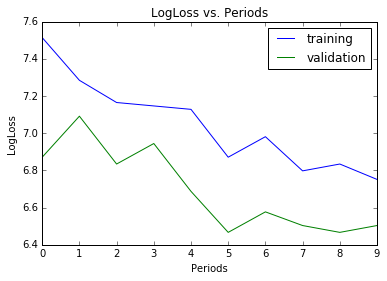

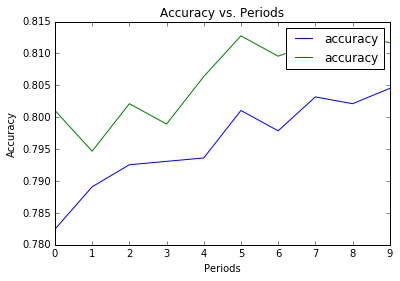

CPU times: user 43min 1s, sys: 1min 34s, total: 44min 36s
Wall time: 44min 50s


In [13]:
%%time
mobilenet_trained_model = train_mobilenet_model(
    learning_rate = 0.003,
    steps=500,
    batch_size=100,
    training_examples=training_examples,
    training_targets=training_labels,
    validation_examples=validation_examples,
    validation_targets=validation_labels) 